<a href="https://colab.research.google.com/github/urieliram/analog/blob/main/sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [1]:
!pip install spectrum
!pip install dtw-python
!pip install dtreeviz
!pip install sktime
!pip install pmdarima
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import time
import timeit
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt

import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV, Lasso, Ridge, BayesianRidge, LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from dtw import *
from scipy import stats

from sktime.forecasting.arima import AutoARIMA

%matplotlib inline
sns.set_theme(style="white")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Load data

In [3]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1057_dPk6rIZgXVku8kmZjq3m8WQNkJZb/view?usp=sharing'
df = pd.read_csv(path+URL.split('/')[-2],usecols=[0,1,2,3,4,5,6,7],names=['Date','SERIE1','SERIE2','SERIE3','SERIE4','SERIE5','SERIE6','SERIE7'],
                 dtype={'Date':str,'SERIE1':float,'SERIE2':float,'SERIE3':float,'SERIE4':float,'SERIE5':float,'SERIE6':float,'SERIE7':float}) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,]
df.dropna(inplace=True)

### ETL 5 minutes

In [4]:
df['Date'] = pd.to_datetime(df['Date'],format= '%d-%m-%Y %H:%M' ) #.dt.date https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html
df = df.set_index('Date')
df_5 = df.resample('5T').mean()
df_5.head()

,SERIE1,SERIE2,SERIE3,SERIE4,SERIE5,SERIE6,SERIE7
Date,,,,,,,
2010-01-01 00:00:00,5547.831152,4353.258496,4927.916309,1355.909058,1697.601026,3396.820703,920.982605
2010-01-01 00:05:00,5535.618164,4348.893457,4916.344433,1353.716626,1699.889233,3397.829590,918.181799
2010-01-01 00:10:00,5529.010351,4331.776856,4897.709473,1346.924121,1697.138647,3424.317334,916.371033
2010-01-01 00:15:00,5514.982032,4330.051758,4879.650098,1346.241382,1705.324194,3421.112500,916.161291
2010-01-01 00:20:00,5472.567285,4314.503906,4863.172266,1334.846802,1674.401562,3409.312451,914.513721


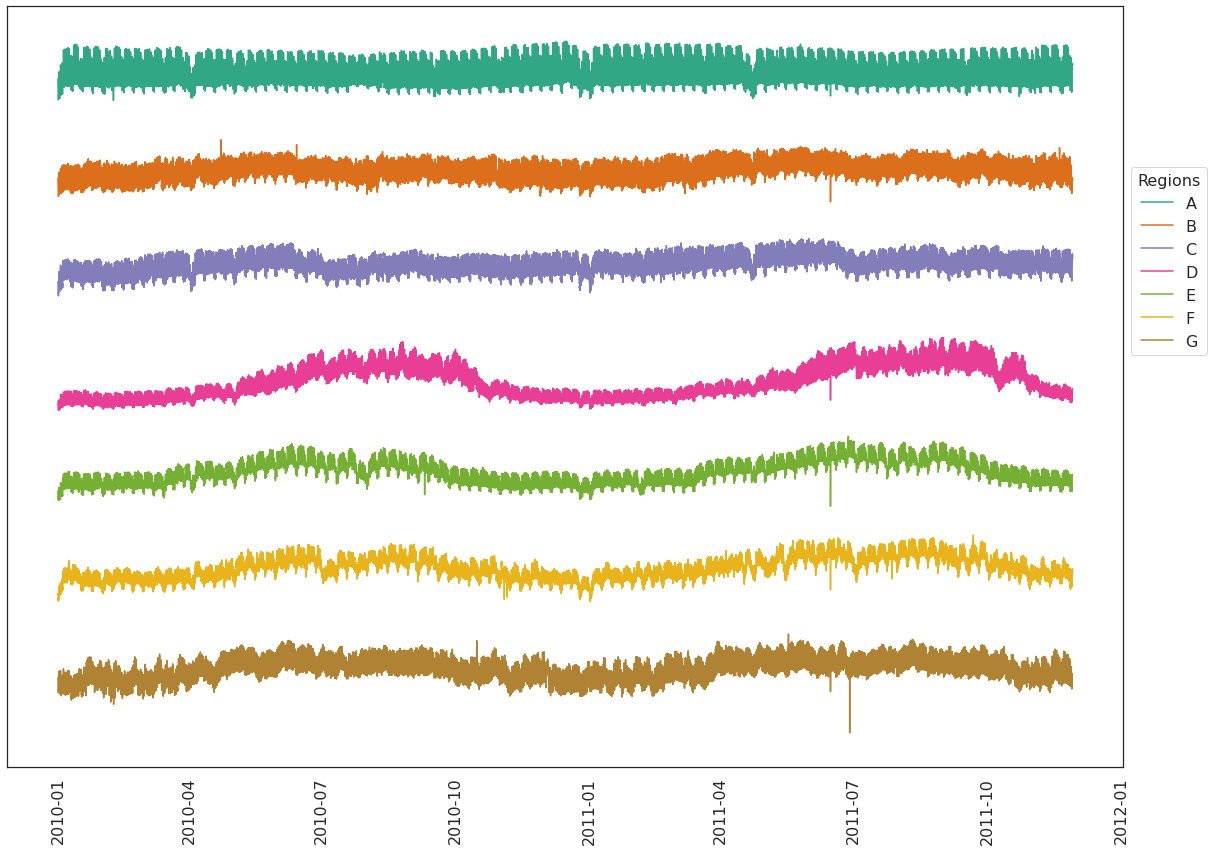

In [5]:
regions = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
if  True:
  i = 0
  j = 0
  cmap = plt.cm.Dark2 #tab20 https://matplotlib.org/stable/gallery/color/colormap_reference.html
  fig, ax = plt.subplots(figsize=(20,14))
  for ts in df_5:
    max_t = df_5[ts].max()
    plt.plot(df_5[ts].index, df_5[ts] / max_t + j, c = cmap(i), label=regions[i], alpha=.9)
    i += 1
    j -= 1
  plt.yticks([])
  plt.xticks(rotation=90, fontsize=16)
  plt.legend(bbox_to_anchor=(1, 0.8), prop={'size': 16}, title="Regions", title_fontsize=16)
  plt.savefig('series.pdf', bbox_inches = 'tight')
  plt.show()

## Functions

### Sample selection

In [6]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [7]:
def diff(list1,list2):
    difference = []
    zip_object = zip(list1, list2)
    for list1_i, list2_i in zip_object:
        difference.append(list1_i-list2_i)
    return difference

In [8]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-"; MAGE="FF00FF";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='fig_t16_serie.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [9]:
def OLSstep(X, Y, X_2, pi_step_=0.001,verbose_=False):
    model   = sm.OLS(Y, X)
    results = model.fit()
    prediction_Y2 = results.predict(X_2)

    ## We sort the 'pi' values and the largest one is selected.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1], reverse=True) ## We order by 'pi'
    (i, pi) = pvalues[0]  

    while pi > pi:
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2)   
        if verbose_==True:
            print('Retiramos regresor ---> X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        model   = sm.OLS(Y, X)
        results = model.fit()

        ## We sort the 'pi' values and select the largest
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## We order by 'pi'
        (i, pi) = pvalues[0]
        #prediction   = results.predict(X)  
        prediction_Y2 = results.predict(X_2)
    if len(prediction_Y2) == 0:      
        if verbose_==True:
            print('>>> Warning, no variable was significant in the regression.')
        model   = sm.OLS(Y, X)
        results = model.fit()
        prediction_Y2 = results.predict(X_2)
        
    if verbose_==True:
        print(results.summary())
    return prediction_Y2   

In [10]:
def RF(X, Y, X_2,labels_,typedist_,verbose_=False):
    model         = RandomForestRegressor(random_state=42)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   
def Boosting(X, Y, X_2,typedist_,verbose_=False):
    model         = GradientBoostingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def Bagging(X, Y, X_2,typedist_,verbose_=False):
    model         = BaggingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   
def AdaBoost(X, Y, X_2,typedist_,verbose_=False):
    model         = AdaBoostRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 
def LinearReg(X, Y, X_2,typedist_,verbose_=False):
    model         = LinearRegression()
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def BayesRidge(X, Y, X_2,typedist_,verbose_=False):
    model         = BayesianRidge(compute_score=True)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2) 
    return prediction_Y2
def LassoReg(X, Y, X_2,typedist_,verbose_=True):
    model         = Lasso(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def RidgeReg(X, Y, X_2,typedist_,verbose_=False):
    model         = Ridge(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2    
def PLS(X, Y, X_2,n_components,typedist_,verbose_=False):
    model         = PLSRegression(n_components=n_components)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def PCR(X, Y, X_2,n_components,typedist_,verbose_=False):
## https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html
    model         = make_pipeline(PCA(n_components=n_components), LinearRegression())
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2

In [11]:
def VotingEnsemble(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    gb  = GradientBoostingRegressor(random_state=42)
    rf  = RandomForestRegressor(random_state=42)
    br  = BaggingRegressor(random_state=42)
    ab  = AdaBoostRegressor(random_state=42)
    gb.fit(X, Y)
    rf.fit(X, Y)
    br.fit(X, Y)
    ab.fit(X, Y)
    voting = VotingRegressor([("gb",gb), ("rf",rf), ("br",br), ("ab",ab)]) #
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)
    return prediction_Y2   

In [12]:
def VotingLinear(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    pl = PLSRegression(n_components=1)
    lr = LinearRegression()
    ri = Ridge(alpha=0.1)
    la = Lasso(alpha=0.1)    
    pc = make_pipeline(PCA(n_components=1), LinearRegression())
    pl.fit(X, Y)
    lr.fit(X, Y)
    ri.fit(X, Y)
    la.fit(X, Y)
    pc.fit(X, Y)
    voting = VotingRegressor([("lr",lr),("ri",ri),("la",la),("pc",pc)]) #,("pl",pl)
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    return prediction_Y2   

In [13]:
def euclidean(neig1, neig2):
	distance = 0.0
	for i in range(len(neig1)):
		distance += (neig1[i] - neig2[i])**2
	return sqrt(distance)

### Forecast

In [36]:
def analogo_knn(serie,vsele,k=10,tol=0.8,n_components=3,typedist='pearson',typereg='OLSstep',verbose=False):
# vesele   : Size of the selection window / Tamanio de la ventana de selección
# k        : Number of neighbours to search for k / Número de vecinos a buscar k
# tol      : Window size tolerance for neighbour selection / Tolerancia de tamaño de ventanas para seleccion de vecinos
# typedist : distance measure, 'euclidian' or 'pearson' or 'dtw' / medida de distancia, 'euclidian' o 'pearson' o 'dtw' 
    t_o = time.time()
    n = len(serie) 

## STEP 1: Selection of the windows with the highest correlation.

    ## Calculate the distance between all neighbors.
    distances = []
    Y = serie[n-vsele:n]           ## latest data
    for i in range(n-2*vsele):                              
        if  typedist == 'dtw':     ## dynamic time warping
            dist = dtw(Y, serie[i:i+vsele]).distance  
        elif typedist == 'euclidian':
            dist = euclidean(Y,serie[i:i+vsele])
        else:
            dist = np.corrcoef(Y,serie[i:i+vsele])[1,0]
        if dist > 0:
            distances.append((i, dist))
        
    ## We calculate the neighbourhood by distance from smallest to largest and the positions are saved.
    if typedist == 'pearson':
        ## In the Pearson backwards case, we are interested in the indices with the highest correlation in Pearson backwards ordering.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## We calculate the k nearest neighbors and save the positions.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(serie[pos:pos+vsele])
            neighbors2.append(serie[pos+vsele:pos+2*vsele])  
        else:
            bandera = True
            for p in positions:
                 ## if we already had a position in the list that passed the tolerance, we no longer save it
                if (abs(pos - p) < tol*vsele):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## save new neighbor
                positions.append(pos)   
                neighbors.append(serie[pos:pos+vsele])
                neighbors2.append(serie[pos+vsele:pos+2*vsele])  
                bandera = False
        i = i + 1
        if i == k:
            break
    if verbose==True:
        print('positions KNN:', positions) ## position of k nearest neighbors

    neighbors  = np.array(neighbors)  
    neighbors2 = np.array(neighbors2)    
    vacia = []
    if verbose==True:
        print_serie2(neighbors,Y,'Selección con KNN:'+typedist,'demanda','time',8,5,'fig_t16_X_'+typedist+'_'+typereg)

    t_sel = time.time() - t_o

## STEP 2: Regression between nearest neighbors 'X' and last window 'Y'

    ## Define our regressors
    X   = (neighbors.T ).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()
    prediction_Y2 = []

    ## -- Random forest regression --
    if typereg == 'RF':
        prediction_Y2 = RF(X,Y,X_2,labels_=positions,typedist_=typedist,verbose_=verbose)

    ## -- OLS with Stepwise --
    if typereg == 'OLSstep':
        prediction_Y2 = OLSstep(X,Y,X_2, pi_step_=0.001,verbose_=verbose)

    ## -- Gradiant boosting regression --
    if typereg == 'Boosting':
        prediction_Y2 = Boosting(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Bagging regression --
    if typereg == 'Bagging':
        prediction_Y2 = Bagging(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Linear regression --
    if typereg == 'LinearReg':
        prediction_Y2 = LinearReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ada boosting --
    if typereg == 'AdaBoost':
        prediction_Y2 = AdaBoost(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Bayesian Ridge --
    if typereg == 'BayesRidge':
        prediction_Y2 = BayesRidge(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Lasso regression --
    if typereg == 'LassoReg':
        prediction_Y2 = LassoReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ridge regression --
    if typereg == 'RidgeReg':
        prediction_Y2 = RidgeReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)

    ## -- PLS Regression --
    if typereg == 'PLS':
        prediction_Y2 = PLS(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- PCA Regression --
    if typereg == 'PCR':
        prediction_Y2 = PCR(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- Voting regression with ensemble models -- 
    if typereg == 'VotingEnsemble':
        prediction_Y2 = VotingEnsemble(X,Y,X_2,verbose_=verbose)

    ## -- Voting regression with linear model -- 
    if typereg == 'VotingLinear':
        prediction_Y2 = VotingLinear(X,Y,X_2,verbose_=verbose)
        
    ## -- Random forrest regression with GridSearchCV--
    #if typereg == 'AutoRF':
    #    prediction_Y2 = AutoRF(X, Y, X_2,labels_=positions,typedist_=typedist,verbose_=verbose)        

    if verbose==True:
        print_serie2(neighbors2,prediction_Y2, 'Forecast - ' + typedist+' - ' + typereg ,'Demand','Time',8,5,'fig_t16_Y2_'+typedist+'_'+typereg)

    t_reg = time.time() - t_sel - t_o
    fail_=False
    if len(prediction_Y2) == 0:
        prediction_Y2=[serie[-1]] * vsele
        fail_=True
        print(">>> analogo_knn: Forecast not calculated.")

    ## Draw an example of an analogous space with X, X' and Y,Y'
    if False:
        fig, ax = plt.subplots(figsize=(8,5))
        ax.legend(['First line', 'Second line'])
        serie1=serie[positions[0]:positions[0]+2*vsele]
        serie2=serie[positions[1]:positions[1]+2*vsele]
        serie3=serie[positions[2]:positions[2]+2*vsele]
        serie4=serie[positions[3]:positions[3]+2*vsele]
        serie5=serie[positions[4]:positions[4]+2*vsele]
        serie6=serie[positions[5]:positions[5]+2*vsele]
        ax.plot(serie1, label='X$_1$')
        ax.plot(serie2, label='X$_2$')
        ax.plot(serie3, label='X$_3$')
        ax.plot(serie4, label='X$_4$')
        ax.plot(serie5, label='X$_5$')
        ax.plot(serie6,label='X$_6$')
        ax.plot(Y,label='Y', linewidth=3, color='r')   
        c = np.concatenate((Y,prediction_Y2), axis=0)   
        ax.plot(c, label='$Y\'$', linewidth=3, color='r',linestyle='--')      
        plt.legend()
        plt.axvline(x = vsele,linestyle='-.')
        ax.set(xlabel='time (5 min)', ylabel='demand (MW)') #title='High correlation windows'
        ax.grid()

        fig.savefig('test'+str(random.randint(1,30000))+'.pdf')
        plt.show()

    return prediction_Y2, t_sel, t_reg, fail_, positions

In [15]:
## Persistence forecasting
def persistence(serie, n=1):
  out = [serie[-1] * n]
  return(out)

In [16]:
def sk_autoarima(x, max_p = 2, max_d = 2, max_q = 2, sp = 1, to_predict = 1):
  forecaster = AutoARIMA(
    start_p = 0, d = 0, start_q = 0, 
    max_p = max_p, max_d = max_d, max_q = max_q, 
    sp = sp,
    suppress_warnings = True
  )
  # Una semana dos horas antes es 2016 + 24 = 2040
  forecaster.fit(x)

  y_pred = forecaster.predict(fh=list(range(1, to_predict + 1)))
  return(y_pred)

In [17]:
def HoltWinters(data,vsele,option='Additive'):
  ##'Additive' 'Multiplicative' 'Additive Dam' 'Multiplicative Dam'
##https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html#Holt%E2%80%99s-Winters-Seasonal
  if option == 'Additive':
    fit = ExponentialSmoothing(
    data,
    seasonal_periods      = vsele,
    trend                 = "add",
    seasonal              = "add",
    use_boxcox            = True,
    initialization_method ="estimated").fit()
  elif option == 'Multiplicative':
    fit = ExponentialSmoothing(
    data,
    seasonal_periods      = vsele,
    trend                 = "add",
    seasonal              = "mul",
    use_boxcox            = True,
    initialization_method = "estimated").fit()
  elif option == 'Additive Dam':
    fit = ExponentialSmoothing(
    data,
    seasonal_periods      = vsele,
    trend                 = "add",
    seasonal              = "add",
    damped_trend          = True,
    use_boxcox            = True,
    initialization_method = "estimated").fit()
  elif option == 'Multiplicative Dam':
    fit = ExponentialSmoothing(
    data,
    seasonal_periods      = vsele,
    trend                 = "add",
    seasonal              = "mul",
    damped_trend          = True,
    use_boxcox            = True,
    initialization_method = "estimated").fit()
  return fit.forecast(vsele)

### Utilities

In [18]:
## Function that given a datetime, returns its position in the series.
def get_index_day(df,day,month,year):
    df_i = df.reset_index()  ## Integer indices are added.
    idxo = df_i[(df_i.Date.dt.day == day) & (df_i.Date.dt.month==month) & (df_i.Date.dt.year==year)].iloc[ 0]
    idxf = df_i[(df_i.Date.dt.day == day) & (df_i.Date.dt.month==month) & (df_i.Date.dt.year==year)].iloc[-1]
    return(idxo.name, idxf.name)

In [19]:
def get_day_from_index(df, indices, forecast):
    """
    Parameters
    ----------
    df : DataFrame
        Original dataframe of the timeseries
    indices : array
        Array of indices
    
    Returns
    -------
    DataFrame
        A DataFrame of dates
    """
    df_i = df.reset_index()  ## Integer indices are added.
    sel_date = df_i.iloc[indices].Date
    t = pd.concat([sel_date.reset_index(), pd.Series(forecast)], axis=1)
    t = t.rename(columns={0 : 'value'})
    return(t)

# Prepare cross-validation for testing

We will use the methodology proposed by Rob J Hyndman [cross-validation in time series](https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
), that is a training dataset of four months followed by a testing dataset of the next month.


In [20]:
## https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
## ... year 2010                                                                                                    year 2011
## ... january···february···march···april···may···june···july···august···september···october···november···december···january···february···march···april···may···june···july···august···september···october···november
##    |                                   |      |
##    |<------------- train ------------->|<test>|
##    |<-january·february···march···april->|<may>|
##            |<-february···march···april···may->|<june>|
##                      |<- march···april···may···june ->|<-july->|
##                              |<- april···may···june···july->|<-august->|
##                                     |<-- may···june···july···august->|<-september->|
##                                             |<-june···july···august···september->|<-october->|
##                                                    |<-july···august···september···october->|<-november->|
##                                                           |<-august···september···october···november->|<-december->| ...

df_5_month = df_5.copy()
df_5_month.reset_index(inplace=True)
# https://stackoverflow.com/a/25149272
df_5_month['month'] = df_5_month['Date'].dt.month
df_5_month['year' ] = df_5_month['Date'].dt.year
df_5_month = df_5_month.drop_duplicates(['month', 'year'])
df_5_month.index

Int64Index([     0,   8928,  16992,  25920,  34560,  43488,  52128,  61056,
             69984,  78624,  87552,  96192, 105120, 114048, 122112, 131040,
            139680, 148608, 157248, 166176, 175104, 183744, 192672],
           dtype='int64')

In [21]:
## Get the positions
#  to : training initial position
#  tt : testing initial position
#  tf : time series final position
# month_i = df_5_month.index
# r = range(len(month_i) - 5)
# tuplas = []
# for i in r:
#   tuplas.append((
#     # 1 ene       30 abril            31 may
#     month_i[i], month_i[i + 4] - 1, month_i[i + 5] - 1
#   ))
# tuplas.append((157248, 192671, 200638))
# tuplas

## Public holidays

In [22]:
serie='SERIE1'
print(get_index_day(df_5[serie],10,5,2010))   ## mothers day 2010
print(get_index_day(df_5[serie],10,5,2011))   ## mothers day 2011
print(get_index_day(df_5[serie],24,12,2010))  ## christmas 2010
print(get_index_day(df_5[serie],31,12,2010))  ## new year 2011
print(get_index_day(df_5[serie],1,1,2011))    ## new year 2011

(37152, 37439)
(142272, 142559)
(102816, 103103)
(104832, 105119)
(105120, 105407)


# Parameter and series selection

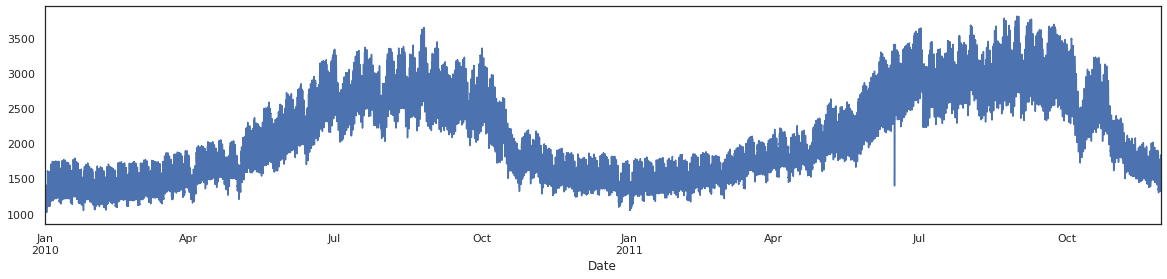

In [23]:
serie4 = df_5.SERIE4
plt.figure(figsize=(20, 4))
serie4.plot()
plt.show()

In [24]:
df_serie4 = serie4.reset_index()
df_serie4.columns = ['date', 'value']
df_serie4

,date,value
0,2010-01-01 00:00:00,1355.909058
1,2010-01-01 00:05:00,1353.716626
2,2010-01-01 00:10:00,1346.924121
3,2010-01-01 00:15:00,1346.241382
4,2010-01-01 00:20:00,1334.846802
...,...,...
200634,2011-11-28 15:30:00,1824.311914
200635,2011-11-28 15:35:00,1832.722339
200636,2011-11-28 15:40:00,1830.256812
200637,2011-11-28 15:45:00,1824.559302


In [25]:
## ene2010... time serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·nov2011
##                |                                               |       |           |
##                |                                               |<-n_p->|           |
##                |<------------------ train -------------------->|<-------test------>|
##                to                                              tt   ...j=0...      tf 

n_p       = 30         ## Number of periods per step (Two and half hour)
vsele     = 288        ## Number of periods in a window (a day)
namefile  = 'forecast'
monthyear = 'jun2010'

##  21 Junio 2010       - 21 Septiembre 2010   Verano
##  21 Septiembre 2010  - 21 Diciembre 2010    Otoño
##  21 Diciembre 2011   - 21 Marzo 2011        Invierno
##  21 Marzo 2011       - 21 Junio 2011        Primavera

In [26]:
df_serie4_summer = df_serie4[(df_serie4.date >='2010-06-21')&(df_serie4.date <'2010-09-21')]

In [27]:
# Each season
df_serie4_summer = df_serie4[(df_serie4.date >='2010-06-21')&(df_serie4.date <'2010-09-21')]
df_serie4_autum  = df_serie4[(df_serie4.date >='2010-09-21')&(df_serie4.date <'2010-12-21')]
df_serie4_winter = df_serie4[(df_serie4.date >='2010-12-21')&(df_serie4.date <'2011-03-21')]
df_serie4_spring = df_serie4[(df_serie4.date >='2011-03-21')&(df_serie4.date <'2011-06-21')]

## Unit test per season

In [28]:
df_serie4_summer

,date,value
49248,2010-06-21 00:00:00,2830.813281
49249,2010-06-21 00:05:00,2827.722998
49250,2010-06-21 00:10:00,2829.968164
49251,2010-06-21 00:15:00,2830.823340
49252,2010-06-21 00:20:00,2830.045606
...,...,...
75739,2010-09-20 23:35:00,3033.962793
75740,2010-09-20 23:40:00,3024.287891
75741,2010-09-20 23:45:00,3021.757666
75742,2010-09-20 23:50:00,3011.382813


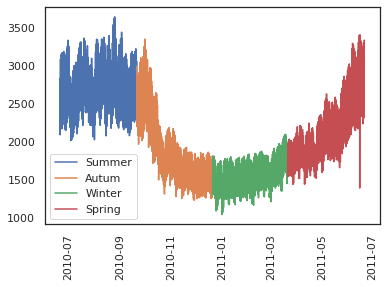

In [29]:
plt.figure()
plt.plot(df_serie4_summer.date, df_serie4_summer.value, label = 'Summer')
plt.plot(df_serie4_autum.date, df_serie4_autum.value, label = 'Autum')
plt.plot(df_serie4_winter.date, df_serie4_winter.value, label = 'Winter')
plt.plot(df_serie4_spring.date, df_serie4_spring.value, label = 'Spring')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [30]:
# Data selection for season; i.e. summer
indices = df_serie4_summer.date - pd.DateOffset(months=4) # select indices
df_serie4_summer_data = df_serie4[
  (df_serie4.date >= indices.values[0]) & (df_serie4.index < df_serie4_summer.index[0])
]
df_serie4_summer_data # train

,date,value
14688,2010-02-21 00:00:00,1391.671289
14689,2010-02-21 00:05:00,1372.883789
14690,2010-02-21 00:10:00,1364.407349
14691,2010-02-21 00:15:00,1353.405566
14692,2010-02-21 00:20:00,1342.204419
...,...,...
49243,2010-06-20 23:35:00,2799.613428
49244,2010-06-20 23:40:00,2810.940430
49245,2010-06-20 23:45:00,2817.902002
49246,2010-06-20 23:50:00,2828.313135


In [31]:
t0 = df_serie4_summer_data.iloc[0] # initial time
tt = df_serie4_summer_data.iloc[-1] # time to
tf = df_serie4_summer.iloc[-1] # final time

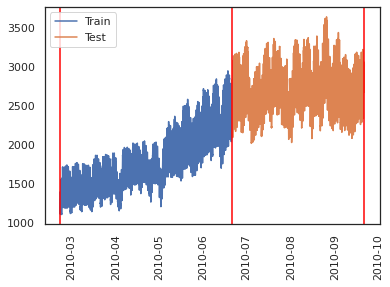

In [32]:
plt.figure()
plt.plot(df_serie4_summer_data.date, df_serie4_summer_data.value, label = 'Train')
plt.plot(df_serie4_summer.date, df_serie4_summer.value, label = 'Test')
plt.xticks(rotation = 90)
plt.axvline(x = t0.date, c = 'red')
plt.axvline(x = tt.date, c = 'red')
plt.axvline(x = tf.date, c = 'red')
plt.legend()
plt.show()

In [33]:
# Access index of t0, etc ╰（‵□′）╯
t0.name

14688

In [34]:
def train_test_season(data, d0 = '2010-06-21', df = '2010-09-21', do = 4, verbose = False):
  # d0: start date
  # df: final date
  # d0: offset date in months
  # df_r: df result
  # t0: start train index
  # tt: end train index / start test index
  # tf: end test index
  df_r = data[(data.date >= d0) & (data.date < df)]
  if verbose:
    plt.figure()
    plt.plot(df_r.date, df_r.value, label = 'df_r')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

  # Data selection for range(d0, df)
  indices = df_r.date - pd.DateOffset(months = do) # select indices
  df_r_data = df_serie4[
    (df_serie4.date >= indices.values[0]) & (df_serie4.index < df_r.index[0])
  ]
  t0 = df_r_data.iloc[0] # initial time
  tt = df_r_data.iloc[-1] # time to
  tf = df_r.iloc[-1] # final time

  if verbose:
    plt.figure()
    plt.plot(df_r_data.date, df_r_data.value, label = 'Train')
    plt.plot(df_r.date, df_r.value, label = 'Test')
    plt.xticks(rotation = 90)
    plt.axvline(x = t0.date, c = 'red')
    plt.axvline(x = tt.date, c = 'red')
    plt.axvline(x = tf.date, c = 'red')
    plt.legend()
    plt.show()
  
  return (t0, tt, tf)

In [35]:
t0, tt, tf = train_test_season(df_serie4, d0 = '2010-06-21', df = '2010-09-21', do = 4, verbose = False)
#print(t0, tt, tf)
print(t0.name, tt.name, tf.name) # indices
t0=t0.name
tt=tt.name
tf=tf.name

14688 49247 75743


# Multi-period forecast metafunction **II**:

## Test series

In [39]:
serie1 = serie4.to_numpy(serie4)
serie1

array([1355.9090576 , 1353.7166262 , 1346.924121  , ..., 1830.2568116 ,
       1824.5593018 , 1825.84985367])

In [40]:
## Prepare the test series (real data)

positions_test = [(t0, tt, tf)]

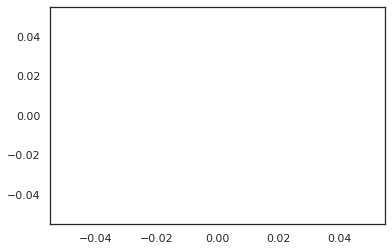

In [41]:
## Non-numeric
nonumeric=[]
j=0
aux=100
for item in serie1:
  if math.isnan(item):
    nonumeric.append(j)   
    print(j,df_5[serie].index[j],df_5[serie][j])
  j=j+1
plt.plot(nonumeric)
#plt.plot(serie1[131640 -aux:131651 +aux])
#print(df_5[serie].index[0])

## Persistence

In [ ]:
## Persistence t+1
forecastp_ = []
time_      = []
for to,tt,tf in positions_test:
  j=0
  for i in range(tt, tf, 1):
    t_o = time.time()
    forecastp_=forecastp_+persistence(serie1[to+j:tt+j],1)
    time_.append(time.time() - t_o)
    j = j + 1

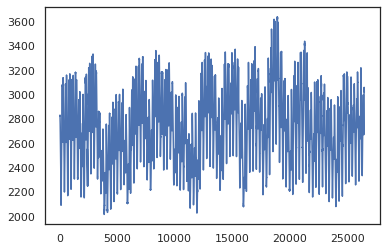

In [ ]:
plt.plot(forecastp_)

## AutoARIMA

In [ ]:
for to,tt,tf in positions_test:
  print(df_5.iloc[to].name)

timeARIMA_       = []
forecastARIMA_   = []
forecastX_ARIMA_ = []
n_p              = n_p  ## Number of periods per step
nfail            = 0

# We need to use series with timestamp indices, like the ones contained in df_5.SERIE1
for to,tt,tf in positions_test:
  j = 0
  s = n_p
  for i in range(tt,tf,1):
    ## Analogue method parameters
    vsele   = vsele ## Number of periods in a window
    X_train = df_5.SERIE1[
      df_5.iloc[to+j].name : df_5.iloc[tt+j].name # from to+j to tt+j in timestamps (.name returns timestamp index)
    ]
    X_train = X_train[-7 * vsele:-1]
    t_o = time.time()
    try:
      pred_ = sk_autoarima(x = X_train, max_p = 10, max_d = 2, max_q = 10, to_predict = vsele) # sp = 1 -> No estacional
    except:
      print("!!! Error has occurred in the position:",tt+j)
      pred_ = np.array(persistence(X_train, n = vsele))
      nfail = nfail + 1
    pred_list  = pred_.tolist() 
    forecastARIMA_ = forecastARIMA_ + pred_list[0:1]
    print(j)
    
    if s == n_p:
      pred_list  = pred_.tolist() 
      forecastX_ARIMA_ = forecastX_ARIMA_ + pred_list[0:n_p]
      s = 0
    
    timeARIMA_.append(time.time() - t_o)
    j = j + 1
    s = s + 1

  modu = (tf - tt) % n_p
  if modu != 0:
    end = min(len(forecastARIMA_), len(forecastX_ARIMA_))
    print('modu', modu)
    forecastARIMA_    = forecastARIMA_[0:end]
    forecastX_ARIMA_  = forecastX_ARIMA_[0:end]        
print('>>>Number of forecasts not calculated:', nfail)

In [ ]:
filter(lambda x: x < 8000, forecastARIMA_)

In [ ]:
plt.figure()
# https://www.geeksforgeeks.org/filter-in-python/
plt.plot(list(filter(lambda x: x < 8000, forecastARIMA_)))

In [ ]:
plt.hist(timeARIMA_)

In [ ]:
np.savetxt("results/data/timeARIMA_.txt", np.asarray([ timeARIMA_ ]), delimiter=",")

In [ ]:
positions_test

In [ ]:
list(range(43487, 43987))

In [ ]:
t = get_day_from_index(df_5[serie], indices= list(range(43487, 43987)), forecast = forecastARIMA_)
t

In [ ]:
t.to_csv("results/data/forecastARIMA_.csv", index = False)

In [ ]:
t = get_day_from_index(df_5[serie], indices= list(range(43487, 43987)), forecast = forecastX_ARIMA_)
t.to_csv("results/data/forecastX_ARIMA_.csv", index = False)

## Holt-winters

In [ ]:
timeHWA_       = []
forecastHWA_   = []
forecastX_HWA_ = []
n_p            = n_p  ## Number of periods per step
nfail          = 0
dias           = 28

for to,tt,tf in positions_test:
  j = 0
  s = n_p
  for i in range(tt,tf,1):
    vsele = vsele ## Number of periods in a window
    X_train = serie1[to+j:tt+j]
    X_train = X_train[-dias*vsele:-1] ## funcionó bien con 28 dias atras
    t_o = time.time()
    try:
      pred_ = HoltWinters(X_train,vsele,option='Additive') 
    except:
      print("!!! Error has occurred in the position:",tt+j)
      pred_ = np.array(persistence(X_train, n = vsele))
      nfail = nfail + 1
    pred_list  = pred_.tolist() 
    forecastHWA_ = forecastHWA_ + pred_list[0:1]
    print(j)
    
    if s == n_p:
      pred_list  = pred_.tolist() 
      forecastX_HWA_ = forecastX_HWA_ + pred_list[0:n_p]
      s = 0
    
    timeHWA_.append(time.time() - t_o)
    j = j + 1
    s = s + 1

  modu = (tf - tt) % n_p 
  if modu != 0:
    end = min(len(forecastHWA_), len(forecastX_HWA_))
    print('modu', modu)
    forecastHWA_    = forecastHWA_[0:end]
    forecastX_HWA_  = forecastX_HWA_[0:end]        
print('>>>Number of forecasts not calculated:', nfail)

In [ ]:
timeHWM_       = []
forecastHWM_   = []
forecastX_HWM_ = []
n_p            = n_p  ## Number of periods per step
nfail          = 0
dias           = 28

for to,tt,tf in positions_test:
  j = 0
  s = n_p
  for i in range(tt,tf,1):
    vsele = vsele ## Number of periods in a window
    X_train = serie1[to+j:tt+j]
    X_train = X_train[-dias*vsele:-1] ## funcionó bien con 28 dias atras
    t_o = time.time()
    try:
      pred_ = HoltWinters(X_train,vsele,option='Multiplicative') ##'Additive' 'Multiplicative' 'Additive Dam' 'Multiplicative Dam'
    except:
      print("!!! Error has occurred in the position:",tt+j)
      pred_ = np.array(persistence(X_train, n = vsele))
      nfail = nfail + 1
    pred_list  = pred_.tolist() 
    forecastHWM_ = forecastHWM_ + pred_list[0:1]
    print(j)
    
    if s == n_p:
      pred_list  = pred_.tolist() 
      forecastX_HWM_ = forecastX_HWM_ + pred_list[0:n_p]
      s = 0
    
    timeHWM_.append(time.time() - t_o)
    j = j + 1
    s = s + 1

  modu = (tf - tt) % n_p 
  if modu != 0:
    end = min(len(forecastHWM_), len(forecastX_HWM_))
    print('modu', modu)
    forecastHWM_    = forecastHWM_[0:end]
    forecastX_HWM_  = forecastX_HWM_[0:end]        
print('>>>Number of forecasts not calculated:', nfail)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


0


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


2


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


4


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


5


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


6


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


7


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


8


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


10


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


11


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


14


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


15


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


16


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


17


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


18


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


19


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


20


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


21


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


22


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


23


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


24


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


25


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


26


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


27


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


28


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


29


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


30


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


31


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


32


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


33


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


34


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


35


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


36


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


37


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


38


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


39


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


40


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


41


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


42


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


43


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


44


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


45


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


46


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


47


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


48


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


49


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


50


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


51


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


52


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


53


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


54


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


55


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


56


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


57


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


58


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


59


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


60


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


61


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


62


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


63


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


65


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


66


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


67


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


68


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


69


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


70


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


71


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


72


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


73


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


74


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


75


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


76


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


77


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


78


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


79


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


80


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


81


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


82


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


83


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


84


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


85


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


86


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


87


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


88


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


89


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


90


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


91


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


92


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


93


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


94


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


95


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


96


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


97


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


98


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


99


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


100


## AnMA Analog

In [45]:
for to,tt,tf in positions_test:
  j=0
  s=n_p
  for i in range(tt,tf,1):
    X_train = numpy.array(serie1[to+j:tt+j])
    pred_, t_sel_, t_reg_, fail_, positions = analogo_knn(X_train, vsele=288, k = 10, tol = 0.8, typedist = 'pearson', typereg = 'PCR', verbose=False)
    break

In [47]:
n = len(X_train)
Y = X_train[n - 288 : n]

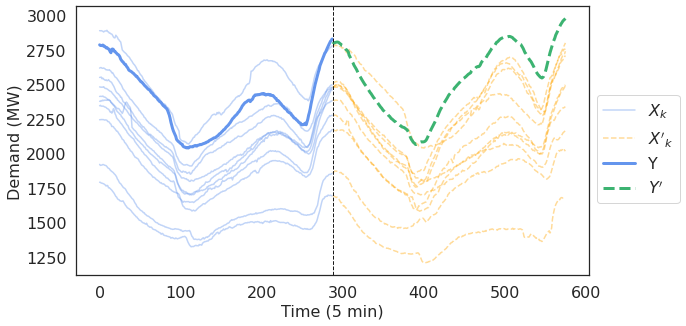

In [153]:
plt.figure(figsize=(10,5))
plt.legend(['First line', 'Second line'])
plt.plot([], [], label='$X_k$', c = 'cornflowerblue', alpha = 0.4)
plt.plot([], [], '--', label='$X\'_k$', c = 'orange', alpha = 0.4)
for i in range(len(positions)):
  serie = X_train[positions[i] : positions[i]+vsele]
  serie2 = X_train[positions[i] + vsele : positions[i] + 2*vsele]
  plt.plot(serie, c = 'cornflowerblue', alpha = 0.4)
  plt.plot(range(vsele, vsele*2), serie2, '--', c = 'orange', alpha = 0.4)

plt.plot(Y,label='Y', color='cornflowerblue', linewidth = 3)   
plt.plot(range(vsele, vsele*2), pred_, label='$Y\'$', color='mediumseagreen',linestyle='--', linewidth = 3)      

plt.axvline(x = vsele, linestyle='--', c = 'k', linewidth = 1)

plt.xlabel('Time (5 min)', fontsize = 16)
plt.ylabel('Demand (MW)', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.legend(bbox_to_anchor=(1, 0.7), fontsize = 16)
plt.tight_layout()
plt.savefig('neighbors_example.pdf')
plt.show()

In [ ]:
timeAn_         = []
forecastAn_     = []
forecastAnMA_   = []
forecastX_An_   = []
forecastX_AnMA_ = []
k               = 5          ## Number of nearest neighbors
tol             = 0.8        ## Closest tolerance percentage between neighbors
typedist        = 'pearson'  ## Distance betweeen neighbors: 'pearson' 'euclidian' 'lb_keogh' 'matrixprofile'
typereg         = 'PCR'      ## Regression model: 'OLSstep' 'Boosting' 'Bagging' 'LinearReg' 'AdaBoost' 'BayesRidge' 'LassoReg' 'RidgeReg' 'PLS' 'PCR' 'VotingEnsemble' 'VotingLinear'
n_p             = n_p        ## Number of periods per step
nfail           = 0
fail_           = False
vsele           = vsele      ## Number of periods in a window

for to,tt,tf in positions_test:
    j=0
    s=n_p
    for i in range(tt,tf,1):
        ## Analogue method parameters
        X_train = numpy.array(serie1[to+j:tt+j])
        t_o = time.time()
        try:
            pred_, t_sel_, t_reg_, fail_, positions = analogo_knn(X_train, vsele=vsele, k=k, tol=tol, typedist=typedist, typereg=typereg, verbose=False)
        except:
            print("!!! Error has occurred in the position:",tt+j)
        if fail_==True:              
            nfail = nfail + 1
            print(">>> Persistence forecast in position:",tt+j)
        pred_list  = pred_.tolist() 
        forecastAn_ = forecastAn_ + pred_list[0:1]
        print(j)
        # Minimum error in the first forecast
        if j >= 3 * n_p:
            a = - 1 - min(j,vsele) 
            b = - 1
            array1 = np.array(forecastAn_[a:b])
            c = tt + j - min(j,vsele)
            d = tt + j
            array2 = np.array(serie1[c:d])                         
            epsilon = np.subtract(array1,array2)  ## Errores del primer pronóstico
            ar = AutoReg(epsilon, lags=int(n_p/2)).fit() ## Ajuste de los últimos n_p/2          
            delta = ar.forecast(1)
            MA_ = pred_list[0:1] - delta
            forecastAnMA_.extend(MA_)
            if s==n_p:
                forecastX_An_   = forecastX_An_ + pred_list[0:n_p]
                MA_ = pred_list[0:n_p] - delta
                forecastX_AnMA_.extend(MA_)
                s=0
        else:
            if s==n_p:
                forecastX_An_   = forecastX_An_ + pred_list[0:n_p]
                forecastX_AnMA_ = forecastX_An_
                s=0
            forecastAnMA_ = forecastAn_

        timeAn_.append(time.time() - t_o)
        j = j + 1
        s = s + 1

    modu=(tf-tt)%n_p
    if modu != 0:
        end=min(len(forecastAn_),len(forecastX_An_))
        print('modu',modu)
        forecastAn_     = forecastAn_[    0:end]
        forecastAnMA_   = forecastAnMA_[  0:end]
        forecastX_AnMA_ = forecastX_AnMA_[0:end]        
        forecastX_An_   = forecastX_An_[  0:end]
print('>>> Number of forecasts not calculated:', nfail)

In [ ]:
date_i = df_5.reset_index().iloc[tt].Date
print('analog:',typereg,typedist)

In [ ]:
df_results = pd.DataFrame({
  'datetime'          : pd.date_range(date_i, periods=len(test_), freq="5T"),
  'Actual'            : test_,
  # 'Persistence'       : forecastp_,
  # 'An '    +typedist+'+'+typereg: forecastAn_,
  # 'AnMA '  +typedist+'+'+typereg: forecastAnMA_,
  # 'HWA '                         : forecastHWA_,
  # 'HWM '                         : forecastHWM_,
  # 'ARIMA '                       : forecastARIMA_,
  'X_An '  +typedist+'+'+typereg: forecastX_An_,
  'X_AnMA '+typedist+'+'+typereg: forecastX_AnMA_,
  'X_HWA '                       : forecastX_HWA_,
  'X_HWM '                       : forecastX_HWM_,
  'X_ARIMA '                     : forecastX_ARIMA_,
})
df_results = df_results.set_index('datetime')

## Save in csv files
df_results.to_csv(namefile+'_'+serie+'_'+monthyear+'.csv')

plt.figure(figsize=(40, 10))
for c in df_results:
  if c == 'Actual':
    plt.plot(df_results[c], '--', label = c)
  else:
    plt.plot(df_results[c], label = c, alpha=0.8)
plt.legend()
plt.ylabel('demand (MW)')
plt.savefig('series_'+monthyear+'.pdf')
plt.show()

In [ ]:
a=0; b=2000
mae_p  = mean_absolute_error(test_[a:b],forecastp_[a:b])
mape_p = mean_absolute_percentage_error(test_[a:b],forecastp_[a:b])
bias_p = bias.bias(test_[a:b],forecastp_[a:b])

mae_a  = mean_absolute_error(test_[a:b],forecastAn_)
mape_a = mean_absolute_percentage_error(test_[a:b],forecastAn_[a:b])
bias_a = bias.bias(test_[a:b],forecastAn_[a:b])

mae_ma  = mean_absolute_error(test_[a:b],forecastAnMA_[a:b])
mape_ma = mean_absolute_percentage_error(test_[a:b],forecastAnMA_[a:b])
bias_ma = bias.bias(test_[a:b],forecastAnMA_[a:b])

mae_xa  = mean_absolute_error(test_[a:b],forecastX_An_)
mape_xa = mean_absolute_percentage_error(test_[a:b],forecastX_An_[a:b])
bias_xa = bias.bias(test_[a:b],forecastX_An_[a:b])

mae_xma  = mean_absolute_error(test_[a:b],forecastX_AnMA_)
mape_xma = mean_absolute_percentage_error(test_[a:b],forecastX_AnMA_[a:b])
bias_xma = bias.bias(test_[a:b],forecastX_AnMA_[a:b])

mae_hwa  = mean_absolute_error(test_[a:b],forecastHWA_)
mape_hwa = mean_absolute_percentage_error(test_[a:b],forecastHWA_[a:b])
bias_hwa = bias.bias(test_[a:b],forecastHWA_[a:b])

mae_xhwa  = mean_absolute_error(test_[a:b],forecastX_HWA_)
mape_xhwa = mean_absolute_percentage_error(test_[a:b],forecastX_HWA_[a:b])
bias_xhwa = bias.bias(test_[a:b],forecastX_HWA_[a:b])

mae_hwm  = mean_absolute_error(test_[a:b],forecastHWM_)
mape_hwm = mean_absolute_percentage_error(test_[a:b],forecastHWM_[a:b])
bias_hwm = bias.bias(test_[a:b],forecastHWM_[a:b])

mae_xhwm  = mean_absolute_error(test_[a:b],forecastX_HWM_)
mape_xhwm = mean_absolute_percentage_error(test_[a:b],forecastX_HWM_[a:b])
bias_xhwm = bias.bias(test_[a:b],forecastX_HWM_[a:b])

mae_arima  = mean_absolute_error(test_[a:b],forecastX_ARIMA_)
mape_arima  = mean_absolute_percentage_error(test_[a:b],forecastX_ARIMA_[a:b])
bias_arima  = bias.bias(test_[a:b],forecastX_ARIMA_[a:b])

mae_xarima  = mean_absolute_error(test_[a:b],forecastX_ARIMA_)
mape_xarima = mean_absolute_percentage_error(test_[a:b],forecastX_ARIMA_[a:b])
bias_xarima = bias.bias(test_[a:b],forecastX_ARIMA_[a:b])

In [ ]:
## One-period
d      = typedist
m      = typereg
data   = [diff(test_,forecastp_), diff(test_,forecastAn_), diff(test_,forecastAnMA_),
          diff(test_,forecastHWA_), diff(test_,forecastHWM_),
          ]
labels = ['Persistence', 'An\n('+d+'+'+m+')', 'AnMA\n('+d+'+'+m+')',
                         'HWA',  'HWM',]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "#FF0000"; # 'pink', 'lightblue', 'lightgreen',
#plt.tick_params(colors = LETRASNARA, which='both')
bplot1 = axes.boxplot(data,
                      vert=True,          # vertical box alignment
                      patch_artist=True,  # fill with color
                      labels=labels,)     # will be used to label x-ticks
#axes.set_title('Accuracy',fontsize='x-large',color = LETRASNARA)
#plt.tick_params(colors = LETRASNARA, which='both')
colors = ['pink', 'lightblue', 'lightgreen',LILA, AZUL] # fill with colors
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
axes.yaxis.grid(True) # adding horizontal grid lines
#axes.set_xlabel('Configuraciones de red',fontsize='large',color = LETRASNARA)
axes.set_ylabel('')
namefile = 'boxplot_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

In [ ]:
## Multi-period
d      = typedist
m      = typereg
data   = [ diff(test_,forecastX_An_), diff(test_,forecastX_AnMA_), 
          diff(test_,forecastX_HWA_), diff(test_,forecastX_HWM_),
           diff(test_,forecastX_ARIMA_), #diff(test_,forecastARIMA_),
          ]
labels = [ 'X_An\n('+d+'+'+m+')', 'X_AnMA\n('+d+'+'+m+')',
                          'X_HWA',  'X_HWM', 'X_ARIMA',]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "#FF0000"; # 'pink', 'lightblue', 'lightgreen',
#plt.tick_params(colors = LETRASNARA, which='both')
bplot1 = axes.boxplot(data,
                      vert=True,          # vertical box alignment
                      patch_artist=True,  # fill with color
                      labels=labels,)     # will be used to label x-ticks
#axes.set_title('Accuracy',fontsize='x-large',color = LETRASNARA)
#plt.tick_params(colors = LETRASNARA, which='both')
colors = ['pink', 'lightblue', 'lightgreen',LILA, AZUL] # fill with colors
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
axes.yaxis.grid(True) # adding horizontal grid lines
#axes.set_xlabel('Configuraciones de red',fontsize='large',color = LETRASNARA)
axes.set_ylabel('')
namefile = 'boxplot_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

In [ ]:
plt.plot(timeAn_, label="AnMA")
plt.plot(timeHWA_, label="HWA")
plt.plot(timeHWM_, label="HWM")
plt.plot(timeARIMA_, label="ARIMA")
plt.ylabel('compute seconds')
plt.xlabel('time')
plt.legend(loc="upper left")

print('time_'+monthyear+'.pdf',((np.mean(timeAn_)*8723)/60)/60 )

namefile = 'timeAn_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)

In [ ]:
df_resultados = pd.DataFrame([
  {
    'method': 'Persistence',
    'mape'  : mape_p,
    'mae'   : mae_p, # Conviene normalizar esto (o quitarlo porque normalizado es como el mape)
    'bias'  : bias_p # Conviene normalizar esto
  },
  {
    'method': 'An \n'+d+'+'+m,
    'mape'  : mape_a,
    'mae'   : mae_a, 
    'bias'  : bias_a 
  },
  {
    'method': 'AnMA \n'+d+'+'+m,
    'mape'  : mape_ma,
    'mae'   : mae_ma,
    'bias'  : bias_ma 
  },
  {
    'method': 'HWA\n',
    'mape'  : mape_hwa,
    'mae'   : mae_hwa,
    'bias'  : bias_hwa
  }, 
  {
    'method': 'HWM\n',
    'mape'  : mape_hwm,
    'mae'   : mae_hwm,
    'bias'  : bias_hwm
  }, 
  {
    'method': 'X_An \n'+d+'+'+m,
    'mape'  : mape_xa,
    'mae'   : mae_xa,
    'bias'  : bias_xa 
  },  
  {
    'method': 'X_AnMA \n'+d+'+'+m,
    'mape'  : mape_xma,
    'mae'   : mae_xma,
    'bias'  : bias_xma
  }, 
  {
    'method': 'X_HWA\n',
    'mape'  : mape_xhwa,
    'mae'   : mae_xhwa,
    'bias'  : bias_xhwa
  },
  {
    'method': 'X_HWM\n',
    'mape'  : mape_xhwm,
    'mae'   : mae_xhwm,
    'bias'  : bias_xhwm
  },
  # {
  #   'method': 'X_ARIMA\n',
  #   'mape'  : mape_xarima,
  #   'mae'   : mae_xarima,
  #   'bias'  : bias_xarima
  # },

  # etc.
])
categories = df_resultados.method
N = len(categories)

fig = plt.figure()
ax = fig.add_subplot(111, projection="polar")

theta = np.arange(len(df_resultados) + 1) / float(len(df_resultados)) * 2 * np.pi

values = df_resultados.mape.values
values = np.append(values, values[0])
values = values + abs(min(values))
values = values / max(values)
ax.plot(theta, values, label="MAPE")

values = df_resultados.bias.values
values = np.append(values, values[0])
values = values + abs(min(values))
values = values / max(values)
ax.plot(theta, values, label="Bias")

plt.xticks(theta[:-1], df_resultados.method, color='grey', size=12)
plt.yticks([0.25, 0.50, 0.75], ['0.25', '0.50', '0.75'], color="grey", size=9)
ax.tick_params(pad=10) # to increase the distance of the labels to the plot

plt.legend(loc='center right', bbox_to_anchor=(0.1, 0.15))

namefile = 'polar_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

# References

*   Jason Brownlee. Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python, (book) 

# To-do

* [ ] Prueba estadística para ver diferencia significativa entre An y AnMA
* [ ] Ajustar el ARIMA
* [ ] Dividir el radial de BIAS y los MAPE en los multi periodo y uni período (pasar a bar plots)
* [ ] Almacenar los resultados en csv
* [ ] Violin plots de error
* [ ] LSTM